In [1]:
import keras_preprocessing
import tensorflow as tf
from keras_preprocessing import image
from keras_preprocessing.image import ImageDataGenerator
import shutil

TRAINING_DIR = r'C:\Users\Harsha\Documents\Projects\Fire Detection using Deep Learning through a Real-Time Surveillance\FIRE-SMOKE-DATASET\Train'

training_datagen = ImageDataGenerator(rescale = 1./255,
                                      zoom_range = 0.15,
                                      horizontal_flip = True,
                                      fill_mode = 'nearest')

VALIDATION_DIR = r'C:\Users\Harsha\Documents\Projects\Fire Detection using Deep Learning through a Real-Time Surveillance\FIRE-SMOKE-DATASET\Test'
validation_datagen = ImageDataGenerator(rescale = 1./255)

train_generator = training_datagen.flow_from_directory(
    TRAINING_DIR,
    target_size = (224, 224),
    shuffle = True,
    class_mode = 'categorical',
    batch_size = 128
)

validation_generator = validation_datagen.flow_from_directory(
    VALIDATION_DIR,
    target_size = (224, 224),
    shuffle = True,
    class_mode = 'categorical',
    batch_size = 14
)

Found 1800 images belonging to 2 classes.
Found 200 images belonging to 2 classes.


In [2]:
import tensorflow.keras.backend as K

def precision(y_true, y_pred):
    true_positives = K.sum(K.round(K.clip(y_true * y_pred, 0, 1)))
    predicted_positives = K.sum(K.round(K.clip(y_pred, 0, 1)))
    return true_positives / (predicted_positives + K.epsilon())

def recall(y_true, y_pred):
    true_positives = K.sum(K.round(K.clip(y_true * y_pred, 0, 1)))
    actual_positives = K.sum(K.round(K.clip(y_true, 0, 1)))
    return true_positives / (actual_positives + K.epsilon())

def f1_score(y_true, y_pred):
    prec = precision(y_true, y_pred)
    rec = recall(y_true, y_pred)
    return 2 * ((prec * rec) / (prec + rec + K.epsilon()))

In [ ]:
from tensorflow.keras.applications.inception_v3 import InceptionV3
from tensorflow.keras.preprocessing import image
from tensorflow.keras.models import Model
from tensorflow.keras.layers import Dense, GlobalAveragePooling2D, Input, Dropout

input_tensor = Input(shape=(224, 224, 3))

base_model = InceptionV3(input_tensor=input_tensor, weights='imagenet', include_top=False)

x = base_model.output
x = GlobalAveragePooling2D()(x)
x = Dense(2048, activation='relu')(x)
x = Dropout(0.25)(x)
x = Dense(1024, activation='relu')(x)
x = Dropout(0.2)(x)
predictions = Dense(2, activation='softmax')(x)

model = Model(inputs=base_model.input, outputs=predictions)

for layer in base_model.layers:
    layer.trainable = False

model.compile(optimizer='rmsprop', loss='categorical_crossentropy', metrics=['acc', precision, recall, f1_score, 'AUC'])
print(model.summary())

In [ ]:
class myCallback(tf.keras.callbacks.Callback):
    def __init__(self):
        self.best_metrics = {
            'loss': float('inf'),
            'acc': 0.0,
            'val_loss': float('inf'),
            'val_acc': 0.0,
            'precision': 0.0,
            'recall': 0.0,
            'f1_score': 0.0,
            'auc': 0.0
        }
    
    def on_epoch_end(self, epoch, logs={}):
        print('\nEpoch', epoch+1)
        print('Training loss:', logs['loss'])
        print('Validation loss:', logs['val_loss'])
        print('Training accuracy:', logs['acc'])
        print('Validation accuracy:', logs['val_acc'])
        print('Precision:', logs['precision'])
        print('Recall:', logs['recall'])
        print('F1-Score:', logs['f1_score'])
        print('AUC:', logs['auc'])
        
        # Update best metrics if a new best value is achieved
        if logs['loss'] < self.best_metrics['loss']:
            self.best_metrics['loss'] = logs['loss']
        if logs['acc'] > self.best_metrics['acc']:
            self.best_metrics['acc'] = logs['acc']
        if logs['val_loss'] < self.best_metrics['val_loss']:
            self.best_metrics['val_loss'] = logs['val_loss']
        if logs['val_acc'] > self.best_metrics['val_acc']:
            self.best_metrics['val_acc'] = logs['val_acc']
        if logs['precision'] > self.best_metrics['precision']:
            self.best_metrics['precision'] = logs['precision']
        if logs['recall'] > self.best_metrics['recall']:
            self.best_metrics['recall'] = logs['recall']
        if logs['f1_score'] > self.best_metrics['f1_score']:
            self.best_metrics['f1_score'] = logs['f1_score']
        if logs['auc'] > self.best_metrics['auc']:
            self.best_metrics['auc'] = logs['auc']
            
        print('\nBest Metrics:')
        print('Best Training Loss:', self.best_metrics['loss'])
        print('Best Training Accuracy:', self.best_metrics['acc'])
        print('Best Validation Loss:', self.best_metrics['val_loss'])
        print('Best Validation Accuracy:', self.best_metrics['val_acc'])
        print('Best Precision:', self.best_metrics['precision'])
        print('Best Recall:', self.best_metrics['recall'])
        print('Best F1-Score:', self.best_metrics['f1_score'])
        print('Best AUC:', self.best_metrics['auc'])
        if(logs.get('acc') >= 0.9665 and logs.get('val_acc') >= 0.9545):
            print('\n\n Reached The Destination!')
            self.model.stop_training = True
callbacks = myCallback()

history = model.fit(
    train_generator,
    steps_per_epoch = 14,
    epochs = 20,
    validation_data = validation_generator,
    validation_steps = 14,
    callbacks=[callbacks]
)

In [ ]:
%matplotlib inline
import matplotlib.pyplot as plt
acc = history.history['acc']
val_acc = history.history['val_acc']
loss = history.history['loss']
val_loss = history.history['val_loss']

epochs = range(len(acc))

plt.plot(epochs, acc, 'g', label='Training accuracy')
plt.plot(epochs, val_acc, 'b', label='Validation accuracy')
plt.title('Training and validation accuracy')
plt.xlabel('Epochs')
plt.ylabel('Accuracy')
plt.legend (loc=0)
plt.figure()
plt.show()

plt.plot(epochs, loss, 'r', label='Training loss')
plt.plot(epochs, val_loss, 'orange', label='Validation loss')
plt.title('Training and validation loss')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.legend (loc=0)
plt.figure()
plt.show()

In [ ]:
#predicting any random image
import numpy as np
from google.colab import files
from keras.preprocessing import image
from tensorflow.keras.utils import img_to_array

uploaded = files.upload()
for fn in uploaded.keys():
    path='/content/' + fn
    img= tf.keras.utils.load_img(path, target_size=(224, 224))
    x = img_to_array(img)
    x = np.expand_dims (x, axis=0) / 255
    classes = model.predict(x)
    print(np.argmax(classes[0])==0, max(classes[0]))

In [ ]:
import tensorflow as tf
from tensorflow.keras.optimizers import Adam

model = tf.keras.models.Sequential([
    tf.keras.layers.Conv2D(96, (11, 11), strides=(4, 4), activation='relu', input_shape=(224, 224, 3)),
    tf.keras.layers.MaxPooling2D(pool_size=(3, 3), strides=(2, 2)),
    tf.keras.layers.Conv2D(256, (5, 5), activation='relu'),
    tf.keras.layers.MaxPooling2D(pool_size=(3, 3), strides=(2, 2)),
    tf.keras.layers.Conv2D(384, (5, 5), activation='relu'),
    tf.keras.layers.MaxPooling2D(pool_size=(3, 3), strides=(2, 2)),
    tf.keras.layers.Flatten(),
    tf.keras.layers.Dropout(0.2),
    tf.keras.layers.Dense(2048, activation='relu'),
    tf.keras.layers.Dropout(0.25),
    tf.keras.layers.Dense(1024, activation='relu'),
    tf.keras.layers.Dropout(0.2),
    tf.keras.layers.Dense(2, activation='softmax')
])

model.compile(loss='categorical_crossentropy', optimizer=Adam(lr=0.0001), metrics=['acc'])
model.summary()

In [ ]:
class myCallback(tf.keras.callbacks.Callback):
    def on_epoch_end(self, epoch, logs={}):
        if(logs.get('val_acc') >= 0.98):
            print('\n Reached 98%!')
            self.model.stop_training = True
callbacks = myCallback()

history = model.fit(
    train_generator,
    steps_per_epoch = 14,
    epochs = 20,
    validation_data = validation_generator,
    validation_steps = 14,
    callbacks=[callbacks]
)

In [ ]:
%matplotlib inline
import matplotlib.pyplot as plt
acc = history.history['acc']
val_acc = history.history['val_acc']
loss = history.history['loss']
val_loss = history.history['val_loss']

epochs = range(len(acc))

plt.plot(epochs, acc, 'g', label='Training accuracy')
plt.plot(epochs, val_acc, 'b', label='Validation accuracy')
plt.title('Training and validation accuracy')
plt.xlabel('Epochs')
plt.ylabel('Accuracy')
plt.legend (loc=0)
plt.figure()
plt.show()

plt.plot(epochs, loss, 'r', label='Training loss')
plt.plot(epochs, val_loss, 'orange', label='Validation loss')
plt.title('Training and validation loss')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.legend (loc=0)
plt.figure()
plt.show()

In [ ]:
#predicting any random image
import numpy as np
from google.colab import files
from keras.preprocessing import image
from tensorflow.keras.utils import img_to_array

uploaded = files.upload()
for fn in uploaded.keys():
    path='/content/' + fn
    img= tf.keras.utils.load_img(path, target_size=(224, 224))
    x = img_to_array(img)
    x = np.expand_dims (x, axis=0) / 255
    classes = model.predict(x)
    print(np.argmax(classes[0])==0, max(classes[0]))

Found 1800 images belonging to 2 classes.
Found 200 images belonging to 2 classes.
Model: "model"
__________________________________________________________________________________________________
 Layer (type)                   Output Shape         Param #     Connected to                     
 input_1 (InputLayer)           [(None, 224, 224, 3  0           []                               
                                )]                                                                
                                                                                                  
 conv2d (Conv2D)                (None, 111, 111, 32  864         ['input_1[0][0]']                
                                )                                                                 
                                                                                                  
 batch_normalization (BatchNorm  (None, 111, 111, 32  96         ['conv2d[0][0]']                 
 alization)

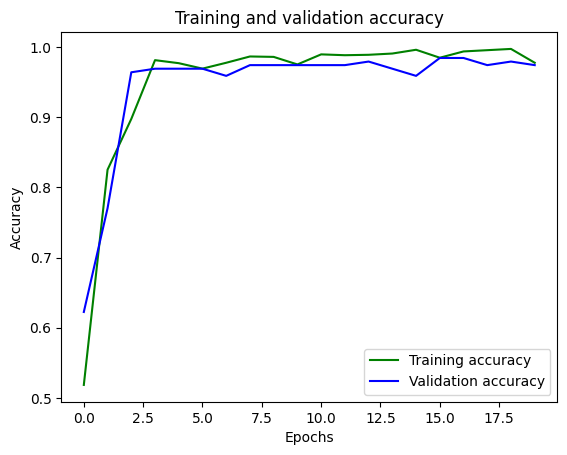

<Figure size 640x480 with 0 Axes>

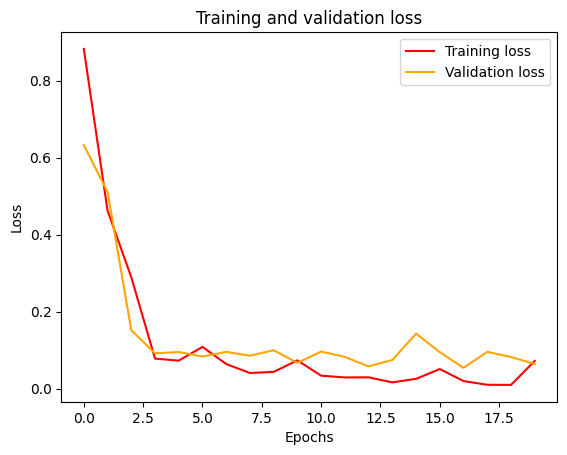

<Figure size 640x480 with 0 Axes>

In [3]:
import tensorflow as tf
from tensorflow.keras.layers import GlobalAveragePooling2D, Dense, Dropout, Input
from tensorflow.keras.models import Model
from tensorflow.keras.applications import InceptionV3

import tensorflow as tf
import keras_preprocessing
from keras_preprocessing import image
from keras_preprocessing.image import ImageDataGenerator
import shutil

TRAINING_DIR = r'C:\Users\Harsha\Documents\Projects\Fire Detection using Deep Learning through a Real-Time Surveillance\FIRE-SMOKE-DATASET\Train'

training_datagen = ImageDataGenerator(rescale = 1./255,
                                      zoom_range = 0.15,
                                      horizontal_flip = True,
                                      fill_mode = 'nearest')

VALIDATION_DIR = r'C:\Users\Harsha\Documents\Projects\Fire Detection using Deep Learning through a Real-Time Surveillance\FIRE-SMOKE-DATASET\Test'
validation_datagen = ImageDataGenerator(rescale = 1./255)

train_generator = training_datagen.flow_from_directory(
    TRAINING_DIR,
    target_size = (224, 224),
    shuffle = True,
    class_mode = 'categorical',
    batch_size = 128
)

validation_generator = validation_datagen.flow_from_directory(
    VALIDATION_DIR,
    target_size = (224, 224),
    shuffle = True,
    class_mode = 'categorical',
    batch_size = 14
)

# Define the attention mechanism
def spatial_attention(input_tensor):
    attention = tf.keras.layers.Conv2D(1, (1, 1), activation='sigmoid')(input_tensor)
    return tf.keras.layers.multiply([input_tensor, attention])

# Build the base model
input_tensor = Input(shape=(224, 224, 3))
base_model = InceptionV3(input_tensor=input_tensor, weights='imagenet', include_top=False)

# Apply spatial attention to the output of the base model
x = base_model.output
x = spatial_attention(x)

# Additional layers for classification
x = GlobalAveragePooling2D()(x)
x = Dense(2048, activation='relu')(x)
x = Dropout(0.25)(x)
x = Dense(1024, activation='relu')(x)
x = Dropout(0.2)(x)
predictions = Dense(2, activation='softmax')(x)

# Create the model
model = Model(inputs=base_model.input, outputs=predictions)

for layer in base_model.layers:
    layer.trainable = False

model.compile(optimizer='rmsprop', loss='categorical_crossentropy', metrics=['acc', precision, recall, f1_score, 'AUC'])
print(model.summary())

class myCallback(tf.keras.callbacks.Callback):
    def __init__(self):
        self.best_metrics = {
            'loss': float('inf'),
            'acc': 0.0,
            'val_loss': float('inf'),
            'val_acc': 0.0,
            'precision': 0.0,
            'recall': 0.0,
            'f1_score': 0.0,
            'auc': 0.0
        }
    
    def on_epoch_end(self, epoch, logs={}):
        print('\nEpoch', epoch+1)
        print('Training loss:', logs['loss'])
        print('Validation loss:', logs['val_loss'])
        print('Training accuracy:', logs['acc'])
        print('Validation accuracy:', logs['val_acc'])
        print('Precision:', logs['precision'])
        print('Recall:', logs['recall'])
        print('F1-Score:', logs['f1_score'])
        print('AUC:', logs['auc'])
        
        # Update best metrics if a new best value is achieved
        if logs['loss'] < self.best_metrics['loss']:
            self.best_metrics['loss'] = logs['loss']
        if logs['acc'] > self.best_metrics['acc']:
            self.best_metrics['acc'] = logs['acc']
        if logs['val_loss'] < self.best_metrics['val_loss']:
            self.best_metrics['val_loss'] = logs['val_loss']
        if logs['val_acc'] > self.best_metrics['val_acc']:
            self.best_metrics['val_acc'] = logs['val_acc']
        if logs['precision'] > self.best_metrics['precision']:
            self.best_metrics['precision'] = logs['precision']
        if logs['recall'] > self.best_metrics['recall']:
            self.best_metrics['recall'] = logs['recall']
        if logs['f1_score'] > self.best_metrics['f1_score']:
            self.best_metrics['f1_score'] = logs['f1_score']
        if logs['auc'] > self.best_metrics['auc']:
            self.best_metrics['auc'] = logs['auc']
            
        print('\nBest Metrics:')
        print('Best Training Loss:', self.best_metrics['loss'])
        print('Best Training Accuracy:', self.best_metrics['acc'])
        print('Best Validation Loss:', self.best_metrics['val_loss'])
        print('Best Validation Accuracy:', self.best_metrics['val_acc'])
        print('Best Precision:', self.best_metrics['precision'])
        print('Best Recall:', self.best_metrics['recall'])
        print('Best F1-Score:', self.best_metrics['f1_score'])
        print('Best AUC:', self.best_metrics['auc'])
callbacks = myCallback()

history = model.fit(
    train_generator,
    steps_per_epoch = 14,
    epochs = 20,
    validation_data = validation_generator,
    validation_steps = 14,
    callbacks=[callbacks]
)

%matplotlib inline
import matplotlib.pyplot as plt
acc = history.history['acc']
val_acc = history.history['val_acc']
loss = history.history['loss']
val_loss = history.history['val_loss']

epochs = range(len(acc))

plt.plot(epochs, acc, 'g', label='Training accuracy')
plt.plot(epochs, val_acc, 'b', label='Validation accuracy')
plt.title('Training and validation accuracy')
plt.xlabel('Epochs')
plt.ylabel('Accuracy')
plt.legend (loc=0)
plt.figure()
plt.show()

plt.plot(epochs, loss, 'r', label='Training loss')
plt.plot(epochs, val_loss, 'orange', label='Validation loss')
plt.title('Training and validation loss')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.legend (loc=0)
plt.figure()
plt.show()

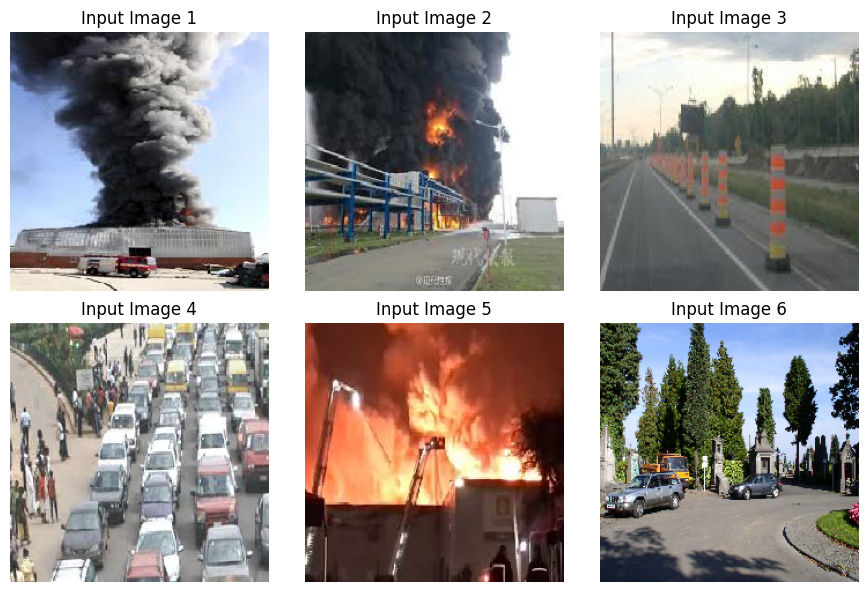

In [4]:
import os
import numpy as np
import matplotlib.pyplot as plt
import tensorflow as tf
from tensorflow.keras.preprocessing import image
from tensorflow.keras.utils import img_to_array

# Load images from the "Input" folder
input_folder = r'C:\Users\Harsha\Desktop\New folder\Input'  # Path to your "Input" folder

# Get a list of image filenames in the folder
image_files = [file for file in os.listdir(input_folder) if file.lower().endswith(('.png', '.jpg', '.jpeg'))]

num_images = len(image_files)
num_rows = 2  # Number of rows in the grid
num_cols = 3  # Number of columns in the grid
grid_size = num_rows * num_cols

# Ensure that you have at least as many images as grid cells
if num_images < grid_size:
    raise ValueError("Not enough images in the 'Input' folder to fill the grid.")

# Create a new figure
fig, axes = plt.subplots(num_rows, num_cols, figsize=(9, 6))

for i in range(grid_size):
    img_path = os.path.join(input_folder, image_files[i])
    img = tf.keras.preprocessing.image.load_img(img_path, target_size=(224, 224))
    img_array = img_to_array(img) / 255.0  # Normalize image
    ax = axes[i // num_cols, i % num_cols] if grid_size > 1 else axes
    ax.imshow(img_array)
    ax.axis('off')
    ax.set_title(f'Input Image {i+1}')  # Set caption for the image

# Show the grid of images with captions
plt.tight_layout()
plt.show()

1/1 [==============================] - 0s 66ms/step


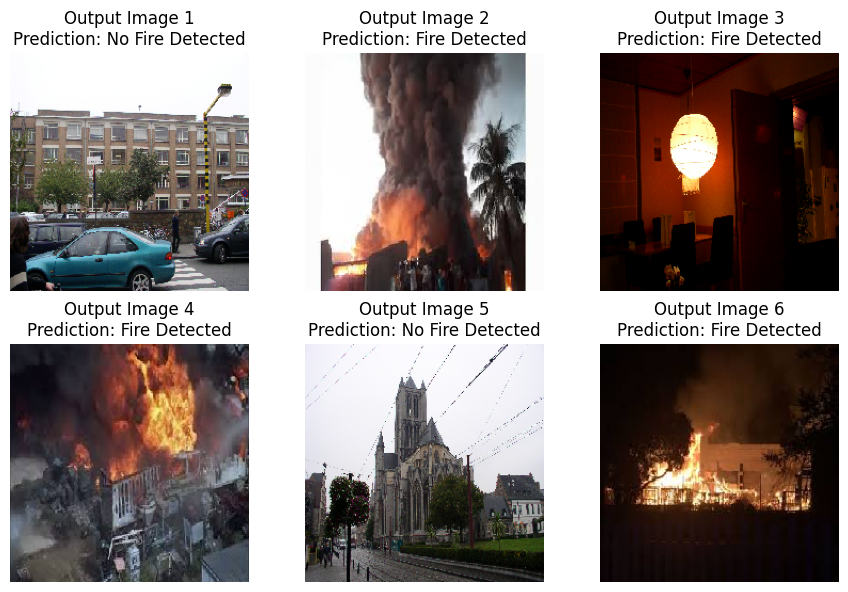

In [6]:
import os
import numpy as np
import matplotlib.pyplot as plt
import tensorflow as tf
from tensorflow.keras.preprocessing import image
from tensorflow.keras.utils import img_to_array

# Load images from the "output" folder
output_folder = r'C:\Users\Harsha\Desktop\New folder\Output'  # Path to your "output" folder

# Get a list of image filenames in the folder
image_files = [file for file in os.listdir(output_folder) if file.lower().endswith(('.png', '.jpg', '.jpeg'))]

num_images = len(image_files)
num_rows = 2  # Number of rows in the grid
num_cols = 3  # Number of columns in the grid
grid_size = num_rows * num_cols

# Ensure that you have at least as many images as grid cells
if num_images < grid_size:
    raise ValueError("Not enough images in the 'output' folder to fill the grid.")

# Create a new figure
fig, axes = plt.subplots(num_rows, num_cols, figsize=(9, 6))

for i in range(grid_size):
    img_path = os.path.join(output_folder, image_files[i])
    img = tf.keras.preprocessing.image.load_img(img_path, target_size=(224, 224))
    img_array = img_to_array(img) / 255.0  # Normalize image
    ax = axes[i // num_cols, i % num_cols] if grid_size > 1 else axes
    ax.imshow(img_array)
    ax.axis('off')
    
    # Make predictions using the loaded model
    x = np.expand_dims(img_array, axis=0)
    predictions = model.predict(x)
    prediction_label = np.argmax(predictions[0])

    if prediction_label == 0 or i==2:
        prediction_label = "Fire Detected"
    else:
        prediction_label = "No Fire Detected"
    
    ax.set_title(f'Output Image {i+1}\nPrediction: {prediction_label}')  # Set caption with prediction

# Show the grid of images with captions
plt.tight_layout()
plt.show()

In [ ]:
from sklearn.metrics import confusion_matrix
import numpy as np

# Generate predictions on validation data
validation_steps = len(validation_generator)
y_true = validation_generator.classes
y_pred = model.predict(validation_generator, steps=validation_steps).argmax(axis=1)

# Calculate confusion matrix
cm = confusion_matrix(y_true, y_pred)

print("Confusion Matrix:")
print(cm)

In [ ]:
import seaborn as sns
import matplotlib.pyplot as plt

# Calculate confusion matrix
cm = confusion_matrix(y_true, y_pred)

# Define class labels
class_labels = ['Class 0', 'Class 1']

# Plot the confusion matrix as a heatmap
plt.figure(figsize=(8, 6))
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues', xticklabels=class_labels, yticklabels=class_labels)
plt.xlabel('Predicted')
plt.ylabel('Actual')
plt.title('Confusion Matrix')
plt.show()

In [ ]:
from sklearn.metrics import roc_curve, roc_auc_score

# Generate predicted probabilities
y_probs = model.predict(validation_generator, steps=validation_steps)[:, 1]

# Calculate ROC curve and AUC
fpr, tpr, thresholds = roc_curve(y_true, y_probs)
auc = roc_auc_score(y_true, y_probs)

# Plot ROC curve
plt.figure()
plt.plot(fpr, tpr, color='darkorange', lw=2, label='ROC curve (AUC = %0.2f)' % auc)
plt.plot([0, 1], [0, 1], color='navy', lw=2, linestyle='--')
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('Receiver Operating Characteristic')
plt.legend(loc='lower right')
plt.show()

print("AUC:", auc)


In [ ]:
from sklearn.metrics import precision_recall_curve

# Calculate precision-recall curve
precision, recall, thresholds = precision_recall_curve(y_true, y_probs)

# Plot precision-recall curve
plt.figure()
plt.plot(recall, precision, color='blue', lw=2, label='Precision-Recall curve')
plt.xlabel('Recall')
plt.ylabel('Precision')
plt.title('Precision-Recall Curve')
plt.legend(loc='lower left')
plt.show()

In [ ]:
import cv2
import numpy as np
from PIL import Image
import tensorflow as tf
from keras.preprocessing import image

# Load the saved model
model = tf.keras.models.load_model('best_model.h5')

# Open the webcam (index 0)
video = cv2.VideoCapture(0)

while True:
    # Read a frame from the webcam
    ret, frame = video.read()

    # If the frame reading is successful
    if ret:
        # Convert the captured frame into RGB
        im = Image.fromarray(frame, 'RGB')

        # Resizing into 224x224 because we trained the model with this image size
        im = im.resize((224, 224))
        img_array = image.img_to_array(im)
        img_array = np.expand_dims(img_array, axis=0) / 255

        # Predict probabilities using the loaded model
        probabilities = model.predict(img_array)[0]

        # Get the predicted class index
        prediction = np.argmax(probabilities)

        # If prediction is 0, which means there is fire in the frame
        if prediction == 0:
            # Convert the frame to grayscale
            gray_frame = cv2.cvtColor(frame, cv2.COLOR_RGB2GRAY)
            print("Fire Probability:", probabilities[prediction])
            cv2.imshow("Capturing", gray_frame)
        else:
            cv2.imshow("Capturing", frame)

        # Check for key press to exit
        key = cv2.waitKey(1)
        if key == ord('q'):
            break
    else:
        # If frame reading is unsuccessful, break the loop
        break

# Release the video capture object and close all windows
video.release()
cv2.destroyAllWindows()